In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime,timedelta

ticker="AAPL"
current_date = datetime.now()
data: pd.DataFrame = yf.download(ticker,
                                 start=current_date - timedelta(days=3625),
                                 end=current_date,
                                 interval="1d")

data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-30,24.610001,24.674999,24.417500,24.537500,21.704288,132040000
2014-07-31,24.290001,24.362499,23.832500,23.900000,21.140387,227372000
2014-08-01,23.725000,24.155001,23.702499,24.032499,21.257595,194044000
2014-08-04,24.092501,24.145000,23.792500,23.897499,21.138180,159832000
2014-08-05,23.840000,23.920000,23.590000,23.780001,21.034245,223732000
...,...,...,...,...,...,...
2024-06-25,209.149994,211.380005,208.610001,209.070007,209.070007,56713900
2024-06-26,211.500000,214.860001,210.639999,213.250000,213.250000,66213200
2024-06-27,214.690002,215.740005,212.350006,214.100006,214.100006,49772700


In [2]:
data = data.reset_index()
data = data[['Date', 'Close']]
data

,Date,Close
0,2014-07-30,24.537500
1,2014-07-31,23.900000
2,2014-08-01,24.032499
3,2014-08-04,23.897499
4,2014-08-05,23.780001
...,...,...
2492,2024-06-25,209.070007
2493,2024-06-26,213.250000
2494,2024-06-27,214.100006
2495,2024-06-28,210.619995


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

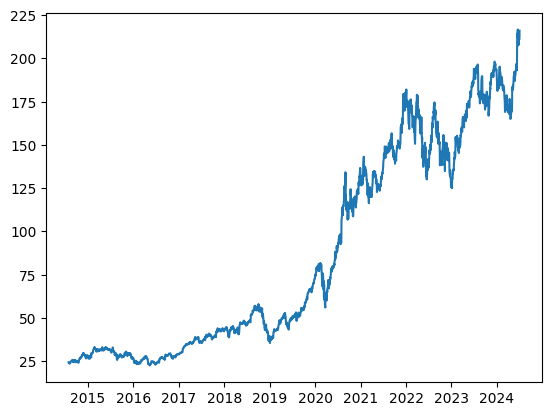

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 10
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date,,,,,,,,,,,
2014-08-13,24.309999,23.992500,23.997499,23.684999,23.620001,23.740000,23.780001,23.897499,24.032499,23.900000,24.537500
2014-08-14,24.375000,24.309999,23.992500,23.997499,23.684999,23.620001,23.740000,23.780001,23.897499,24.032499,23.900000
2014-08-15,24.495001,24.375000,24.309999,23.992500,23.997499,23.684999,23.620001,23.740000,23.780001,23.897499,24.032499
2014-08-18,24.790001,24.495001,24.375000,24.309999,23.992500,23.997499,23.684999,23.620001,23.740000,23.780001,23.897499
2014-08-19,25.132500,24.790001,24.495001,24.375000,24.309999,23.992500,23.997499,23.684999,23.620001,23.740000,23.780001
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-25,209.070007,208.139999,207.490005,209.679993,214.289993,216.669998,212.490005,214.240005,213.070007,207.149994,193.119995
2024-06-26,213.250000,209.070007,208.139999,207.490005,209.679993,214.289993,216.669998,212.490005,214.240005,213.070007,207.149994
2024-06-27,214.100006,213.250000,209.070007,208.139999,207.490005,209.679993,214.289993,216.669998,212.490005,214.240005,213.070007


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 24.30999947,  23.99250031,  23.99749947, ...,  24.03249931,
         23.89999962,  24.53750038],
       [ 24.375     ,  24.30999947,  23.99250031, ...,  23.89749908,
         24.03249931,  23.89999962],
       [ 24.49500084,  24.375     ,  24.30999947, ...,  23.78000069,
         23.89749908,  24.03249931],
       ...,
       [214.1000061 , 213.25      , 209.07000732, ..., 212.49000549,
        214.24000549, 213.07000732],
       [210.61999512, 214.1000061 , 213.25      , ..., 216.66999817,
        212.49000549, 214.24000549],
       [215.97169495, 210.61999512, 214.1000061 , ..., 214.28999329,
        216.66999817, 212.49000549]])

In [7]:
shifted_df_as_np.shape

(2487, 11)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.98222428, -0.98549603, -0.98544452, ..., -0.98508385,
        -0.98644923, -0.97962483],
       [-0.98155446, -0.98222428, -0.98549603, ..., -0.986475  ,
        -0.98508385, -0.98627742],
       [-0.98031788, -0.98155446, -0.98222428, ..., -0.98768579,
        -0.986475  , -0.98489473],
       ...,
       [ 0.97351684,  0.96475773,  0.92168389, ...,  0.95692616,
         0.9749595 ,  0.98779058],
       [ 0.93765615,  0.97351684,  0.96475773, ...,  1.        ,
         0.95692616,  1.        ],
       [ 0.99280415,  0.93765615,  0.97351684, ...,  0.97547461,
         1.        ,  0.98173802]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((2487, 10), (2487,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.97962483, -0.98644923, -0.98508385, ..., -0.98866476,
        -0.98544452, -0.98549603],
       [-0.98627742, -0.98508385, -0.986475  , ..., -0.98544452,
        -0.98549603, -0.98222428],
       [-0.98489473, -0.986475  , -0.98768579, ..., -0.98549603,
        -0.98222428, -0.98155446],
       ...,
       [ 0.98779058,  0.9749595 ,  0.95692616, ...,  0.91210038,
         0.92168389,  0.96475773],
       [ 1.        ,  0.95692616,  1.        , ...,  0.92168389,
         0.96475773,  0.97351684],
       [ 0.98173802,  1.        ,  0.97547461, ...,  0.96475773,
         0.97351684,  0.93765615]])

In [11]:
split_index = int(len(X) * 0.8)

split_index

1989

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1989, 10), (498, 10), (1989,), (498,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1989, 10, 1), (498, 10, 1), (1989, 1), (498, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1989, 10, 1]),
 torch.Size([498, 10, 1]),
 torch.Size([1989, 1]),
 torch.Size([498, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 10, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.463

Val Loss: 0.364
***************************************************

Epoch: 2
Batch 100, Loss: 0.180

Val Loss: 0.189
***************************************************

Epoch: 3
Batch 100, Loss: 0.016

Val Loss: 0.051
***************************************************

Epoch: 4
Batch 100, Loss: 0.005

Val Loss: 0.044
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val Loss: 0.033
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.020
***************************************************

Epoch: 7
Batch 100, Loss: 0.001

Val Loss: 0.014
***************************************************

Epoch: 8
Batch 100, Loss: 0.001

Val Loss: 0.008
***************************************************

Epoch: 9
Batch 100, Loss: 0.001

Val Loss: 0.007
***************************************************

Epoch: 10
Batch 100, Loss: 0.001

Val Loss: 0.006
********************************

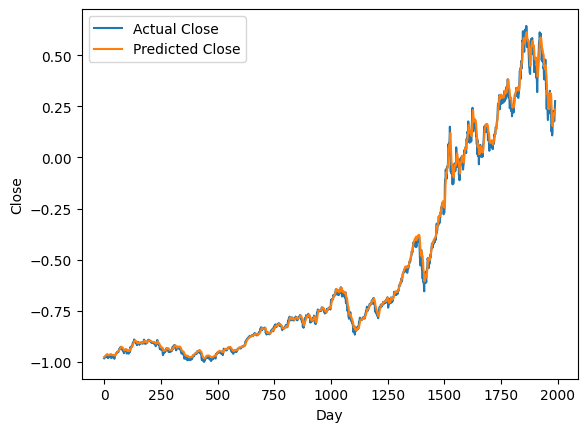

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 24.92667959,  25.00297875,  25.08134288, ..., 140.08810135,
       141.11171678, 142.28701663])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 24.30999884,  24.3750015 ,  24.49500017, ..., 141.55999824,
       142.91999866, 146.35000514])

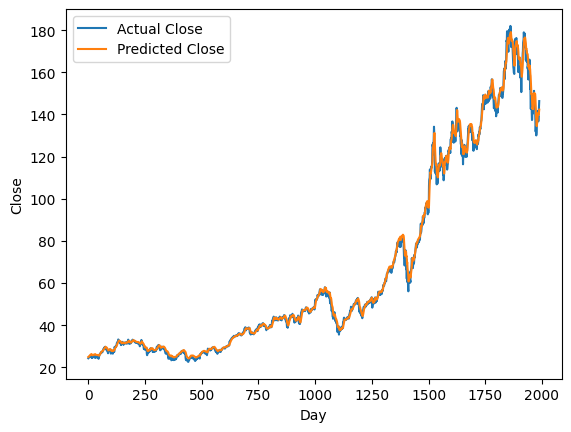

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([144.21790875, 145.82088536, 146.25503462, 146.81524439,
       147.09825293, 148.18850215, 149.52257785, 149.51572937,
       150.63532754, 152.08855742, 153.80526845, 154.68040966,
       154.9297369 , 154.66050628, 155.95501816, 157.10492546,
       159.36835752, 160.79550074, 161.31861074, 163.31630006,
       164.74006531, 165.5899065 , 166.05811882, 166.37941866,
       167.6957774 , 168.50007972, 169.91452087, 171.26213734,
       172.16642505, 173.12962468, 173.74175906, 173.51919523,
       172.33272612, 171.32701853, 170.66391971, 170.8239218 ,
       169.3075749 , 167.4871766 , 165.49711663, 163.54076109,
       162.33821773, 160.91256105, 159.51714986, 158.93678801,
       158.12806658, 158.38120559, 160.38697541, 159.22229531,
       158.63981645, 157.42430494, 155.98038759, 156.06953343,
       156.92068764, 156.63532493, 156.09530197, 154.99310841,
       154.24832535, 154.08087902, 153.40015   , 150.6237476 ,
       147.15401246, 145.9832127 , 146.39787504, 146.90

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([147.03999463, 144.86999448, 145.86000091, 145.49000692,
       148.47000101, 150.16999864, 147.07000876, 151.00000008,
       153.03999202, 155.35000701, 154.08999778, 152.94999591,
       151.60000502, 156.789994  , 157.3500071 , 162.50999352,
       161.50999492, 160.00999413, 166.13000466, 165.80999758,
       165.35000748, 164.86999543, 164.9199968 , 169.24000407,
       168.49000367, 172.10000527, 173.18999999, 173.0299979 ,
       174.5500004 , 174.14999517, 171.52000203, 167.57000611,
       167.22999444, 167.52999981, 170.02999631, 163.61999573,
       161.38000407, 158.91000434, 157.22000179, 157.96000712,
       155.80999711, 154.52999774, 155.96000702, 154.46000623,
       157.36999435, 163.42999397, 153.83999668, 155.30999781,
       152.36999556, 150.69999761, 154.47999637, 156.89999472,
       153.7200009 , 152.7400069 , 150.42999191, 150.77000358,
       151.75999555, 149.8399965 , 142.4799958 , 138.19999629,
       142.44999758, 146.10000693, 146.39999494, 145.42

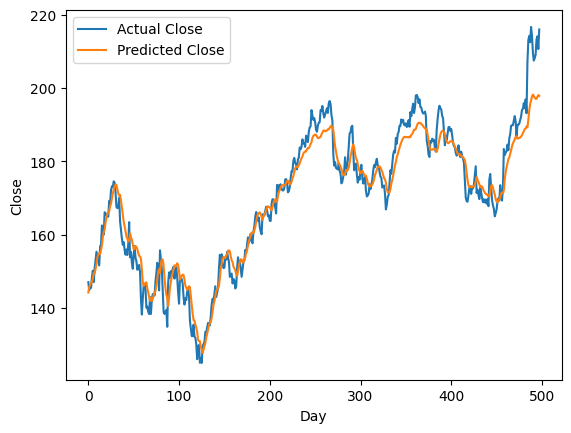

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [30]:
predicted_price = test_predictions[-1]

#r2 = r2_score(y_test, model(X_test).detach().numpy())
#print(model(X_test).detach().numpy())

In [31]:
def evaluate_model(model, X_test, y_test):
    # Ensure the model is in evaluation mode
    model.eval()

    # Perform the forward pass
    with torch.no_grad():
        predictions = model(X_test)

    # Detach the predictions tensor and convert to numpy
    predictions_np = predictions.detach().numpy()

    return mean_squared_error(y_test, predictions_np)

mse = evaluate_model(model, X_test, y_test)

In [32]:
print(f'{ticker} Stock Prices')
print(f'\nStock Price Now: {current_price: 0.2f}')
print(f'Predicted Stock Price: {predicted_price: 0.2f}')
print(f'Mean Squared Error on Test Data: {mse: 0.2f}')

AAPL Stock Prices


NameError: name 'current_price' is not defined